In [1]:
# Import necessary libraries
import pandas as pd

# Load the datasets
customers = pd.read_csv(r"C:\Users\Abhay Thakur\Downloads\Customers.csv")
products = pd.read_csv(r'C:\Users\Abhay Thakur\Downloads\Products.csv')
transactions = pd.read_csv(r'C:\Users\Abhay Thakur\Downloads\Transactions.csv')

# Extract brand name and clean ProductName in products dataset
products['Brand'] = products['ProductName'].str.split().str[0]
products['ProductName'] = products.apply(lambda row: row['ProductName'].replace(row['Brand'] + ' ', ''), axis=1)

# Merge transactions with products and customers datasets
tf = transactions.merge(products[['ProductID', 'Brand', 'ProductName']], on='ProductID', how='left')
tf = tf.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# Convert TransactionDate to datetime format
tf['TransactionDate'] = pd.to_datetime(tf['TransactionDate'])

# Display the first few rows of the merged dataset
display(tf.head())

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,Brand,ProductName,Region
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving,Bluetooth Speaker,Europe
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving,Bluetooth Speaker,Asia
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,ComfortLiving,Bluetooth Speaker,Europe
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving,Bluetooth Speaker,South America
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving,Bluetooth Speaker,Europe


C:\Users\Abhay Thakur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abhay Thakur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin Index: 0.93


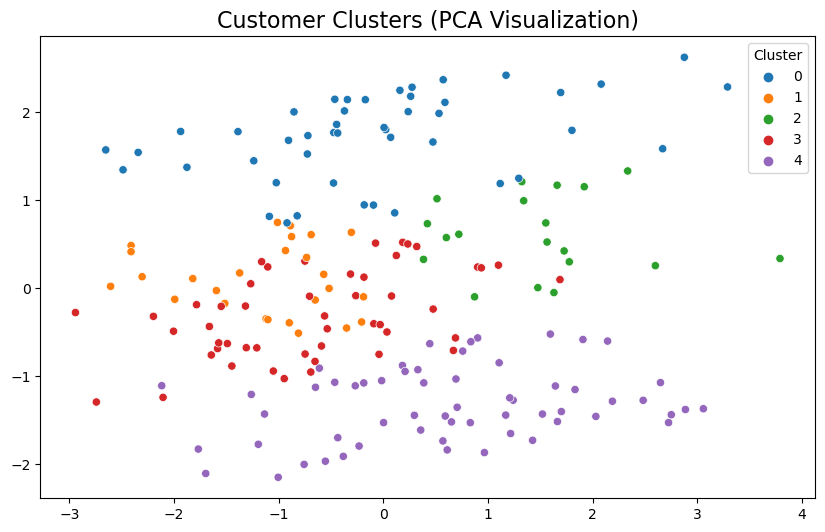

In [2]:
# Task 3 Customer Segmentation

# Import libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


#  Feature Engineering
# Customer-level features
customer_features = tf.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    PurchaseFrequency=('TransactionID', 'count')
).reset_index()

# Add region and days since signup
customers['DaysSinceSignup'] = (pd.Timestamp('2025-01-01') - pd.to_datetime(customers['SignupDate'])).dt.days
customer_features = customer_features.merge(customers[['CustomerID', 'Region', 'DaysSinceSignup']], on='CustomerID')

# One-hot encode the region
customer_features = pd.get_dummies(customer_features, columns=['Region'])

# Normalize features
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features.drop('CustomerID', axis=1))

# Clustering
# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)

# Evaluate clustering
db_index = davies_bouldin_score(customer_features_scaled, customer_features['Cluster'])
print(f'Davies-Bouldin Index: {db_index:.2f}')

#  Visualization
# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(customer_features_scaled)

# Scatter plot for clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_features['Cluster'], palette='tab10')
plt.title('Customer Clusters (PCA Visualization)', fontsize=16)
plt.show()
